In [1]:
import os
import pywt
import torch
import numpy as np
import matplotlib.pyplot as plt
import math 
from torch.utils.data import DataLoader, TensorDataset

# seed the random number generator for reproducibility
np.random.seed(33)

In [3]:
# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_1"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# create the dataset
dataset = TensorDataset(x, y)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128, shuffle=True)

(10000, 1, 1000)
(10000,)


In [4]:
signal_1 = None
signal_2 = None

for batch in test_loader:
    x, y = batch

    for i in range(len(batch)):
        if y[i] == 1:
            signal_1 = x[i, 0, :].numpy()
        else:
            signal_2 = x[i, 0, :].numpy()
        
        if signal_1 is not None and signal_2 is not None:
            break

print(signal_1.shape)
print(signal_2.shape)

(1000,)
(1000,)


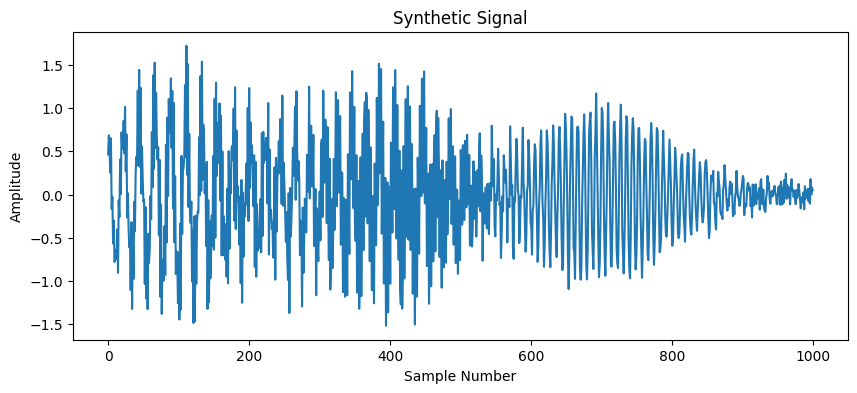

In [ ]:
# plot the signal
plt.figure(figsize=(10, 4))
plt.plot(signal_1)
plt.title('Synthetic Signal 1')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

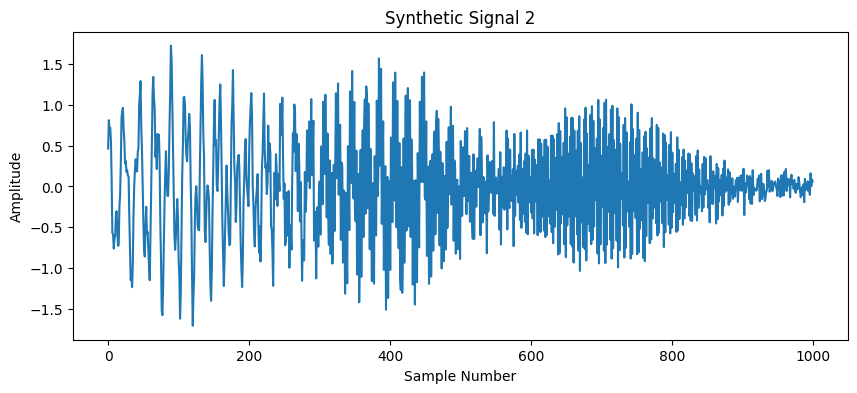

In [70]:
# plot the signal
plt.figure(figsize=(10, 4))
plt.plot(signal_2)
plt.title('Synthetic Signal 2')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

In [71]:
# perfrorm multiscale wavelet transform
# get max level for the multiscale wavelet transform
max_level = pywt.dwt_max_level(len(signal_1), 'db1')

coefs_1 = pywt.wavedec(signal_1, 'db1', level=max_level)
coefs_2 = pywt.wavedec(signal_2, 'db1', level=max_level)

# check if the coefs are real numbers or complex
# for i, coef in enumerate(coefs):
#     print(f"Is Coefficient {i} real? : {np.isrealobj(coef)}")


In [72]:
# print the scaloegram
def plot_dwt_scaleogram_freq(fs, coeffs, level, time, data):
        """
        Plot the scaleogram of the Discrete Wavelet Transform (DWT).
        """

        # Compute frequency bands
        freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
        freq_bands.append(fs / (2 ** level))                        # Nyquist
        freq_bands.append(0)                                        # lowest frequency
        print(freq_bands)

        # flip the frequency bands
        freq_bands = freq_bands[::-1]

        # Prepare the scaleogram
        scaleogram = []
        for i, coeff in enumerate(coeffs):
            factor = math.ceil(len(data)/len(coeff))
            # convert to power and normalize db
            coeff = np.abs(coeff) ** 2

            # multiply each level by 2 to the power of i to normalize
            coeff = coeff * (2 ** i)

            # Upsample coefficients to match the original signal length
            upsampled = np.repeat(coeff, factor)[:len(data)]
            
            scaleogram.append(upsampled)
        scaleogram = np.array(scaleogram)
        scaleogram = scaleogram[:, :(len(data))-1]

        # normalize the scaleogram
        scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)

        # Plot the scaleogram
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(time, freq_bands, np.abs(scaleogram), cmap='viridis')
        plt.colorbar(label='Amplitude')
        plt.title('DWT Scaleogram')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')

        # save the figure
        plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

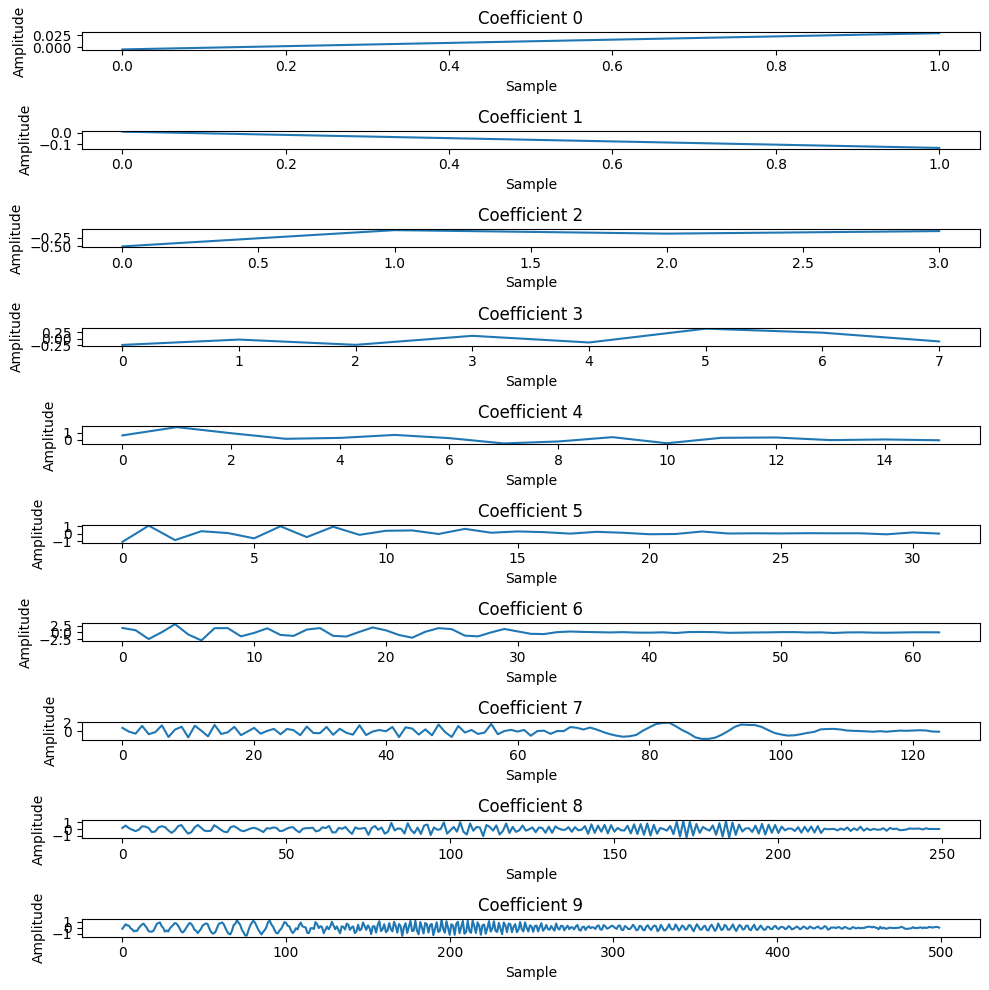

In [73]:
# print all the coefficients
fig, ax = plt.subplots(len(coefs_1), figsize=(10, 10))

for i, coef in enumerate(coefs_1):
    ax[i].plot(coef)
    ax[i].set_title(f'Coefficient {i}')
    ax[i].set_xlabel('Sample')
    ax[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show

[500.0, 250.0, 125.0, 62.5, 31.25, 15.625, 7.8125, 3.90625, 1.953125, 1.953125, 0]


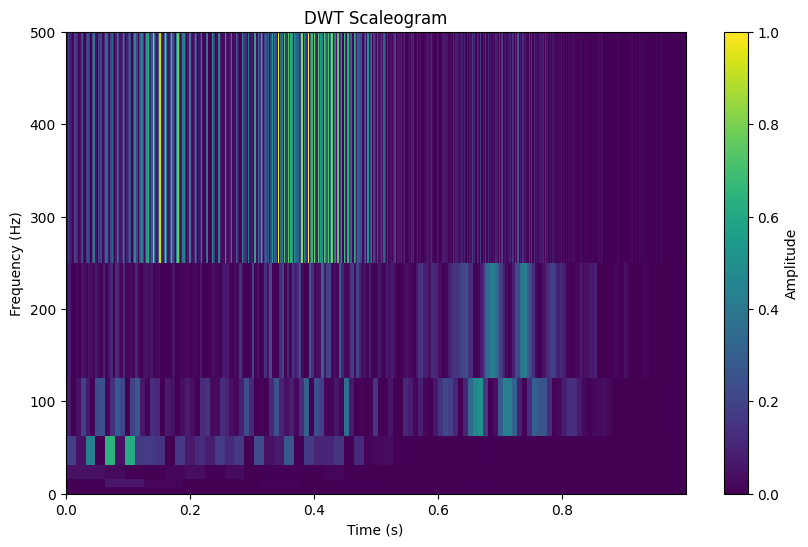

In [74]:
fs = 1000
# create time vector
t = np.arange(0, len(signal_1)) / fs

plot_dwt_scaleogram_freq(fs, coefs_1, max_level, t, signal_1)

[500.0, 250.0, 125.0, 62.5, 31.25, 15.625, 7.8125, 3.90625, 1.953125, 1.953125, 0]


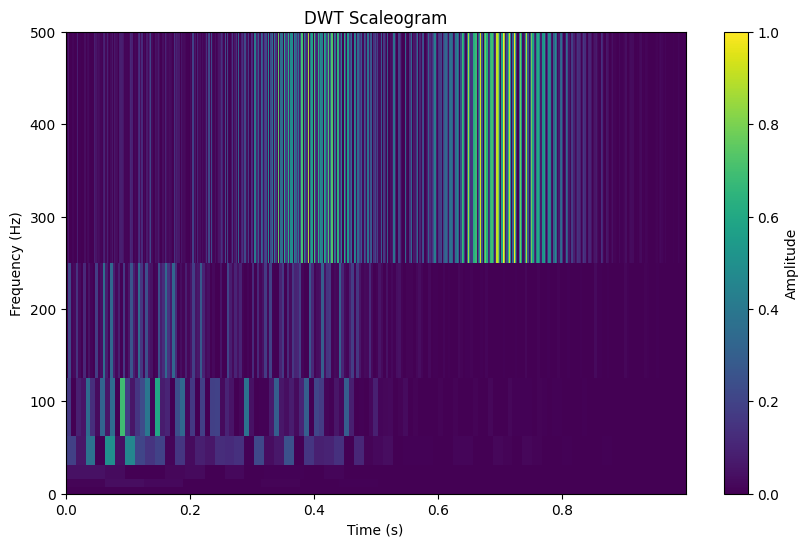

In [75]:
fs = 1000
# create time vector
t = np.arange(0, len(signal_2)) / fs

plot_dwt_scaleogram_freq(fs, coefs_2, max_level, t, signal_2)

Wavelet: sym2
[50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.09765625, 0]


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


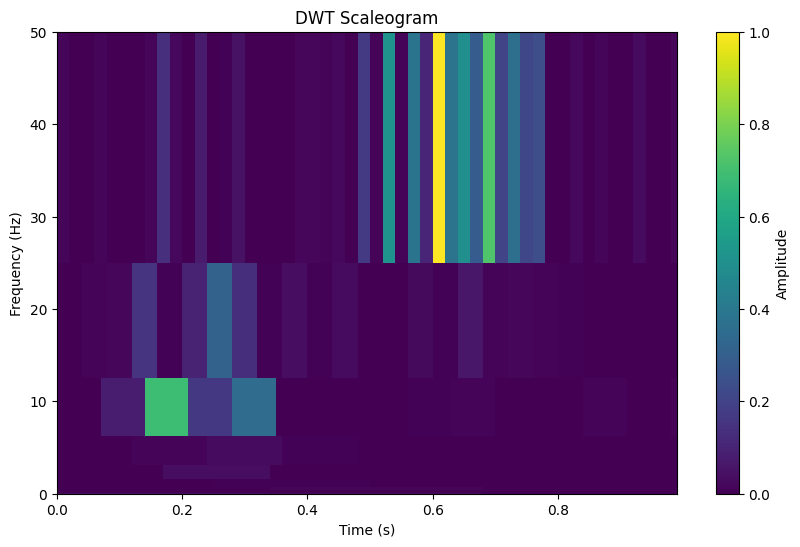

Wavelet: sym3
[50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.09765625, 0]


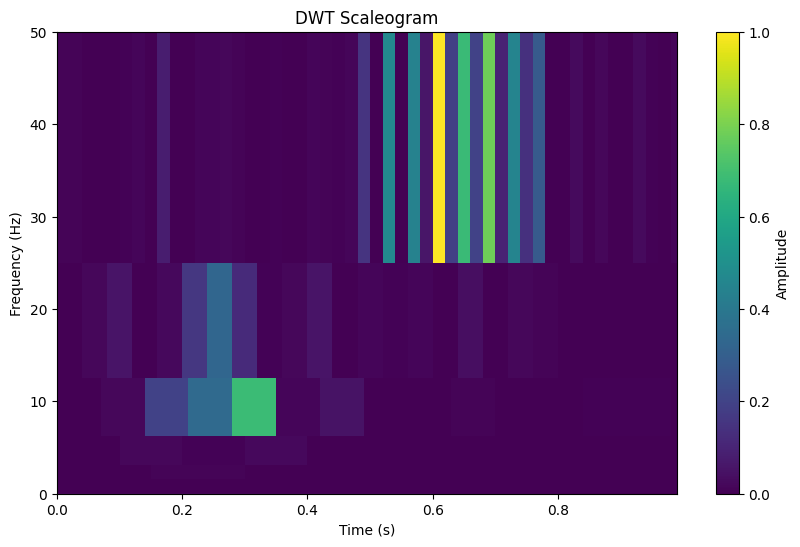

Wavelet: sym4
[50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.09765625, 0]


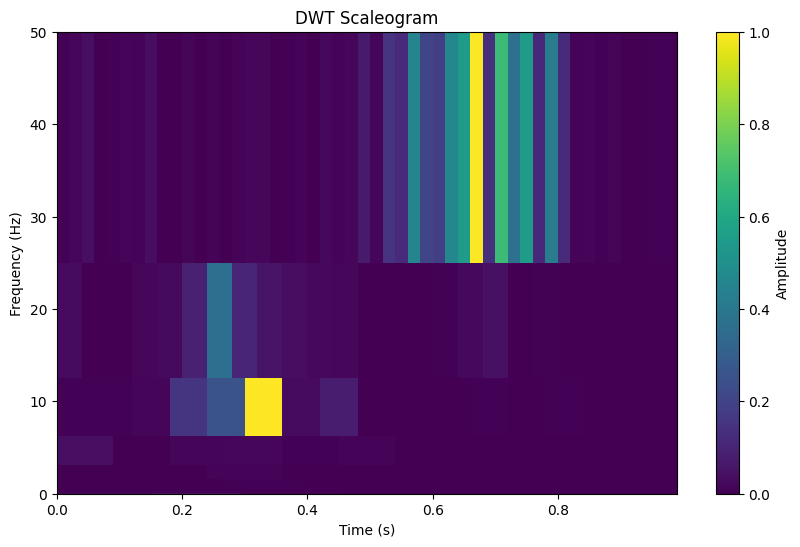

Wavelet: sym5
[50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.09765625, 0]


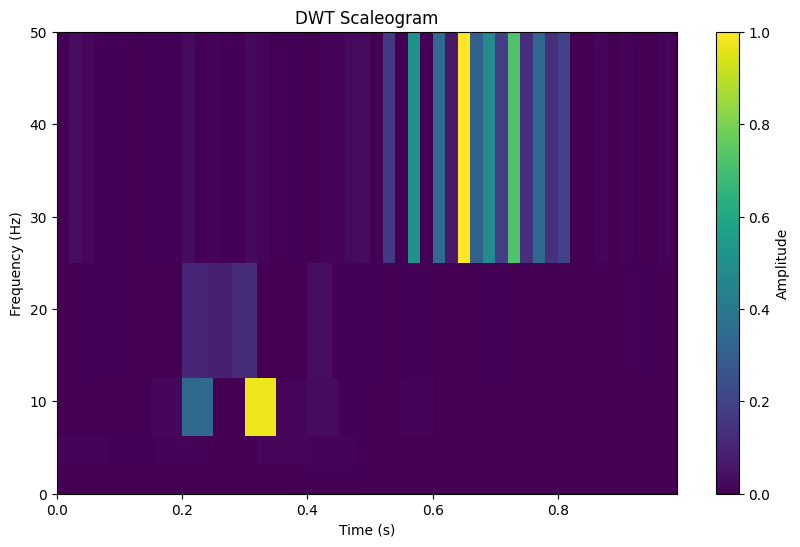

Wavelet: sym6
[50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.09765625, 0]


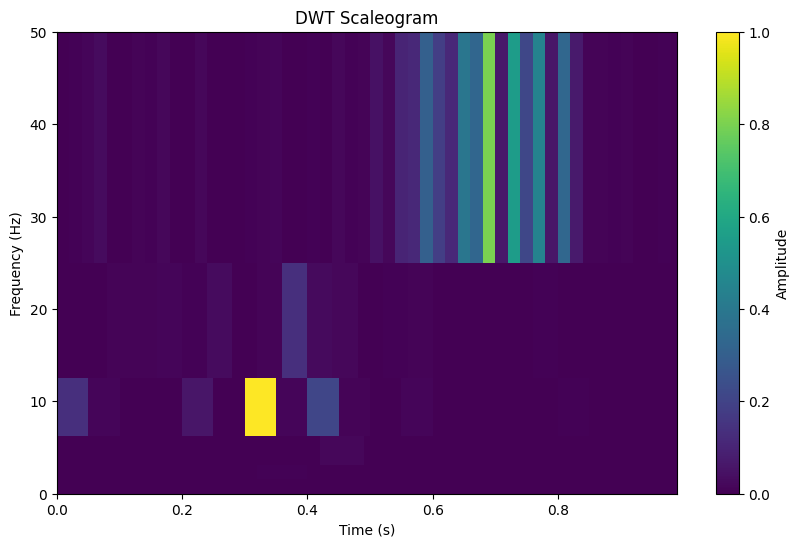

Wavelet: sym7
[50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.09765625, 0]


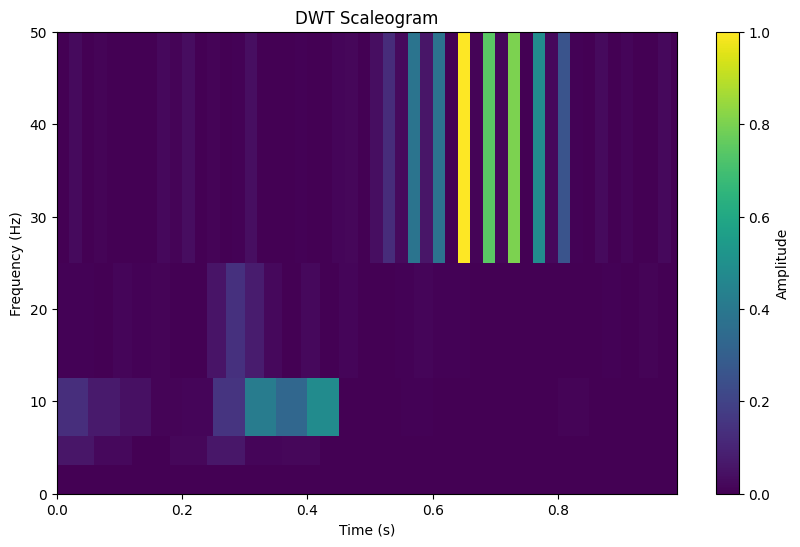

Wavelet: sym8
[50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.09765625, 0]


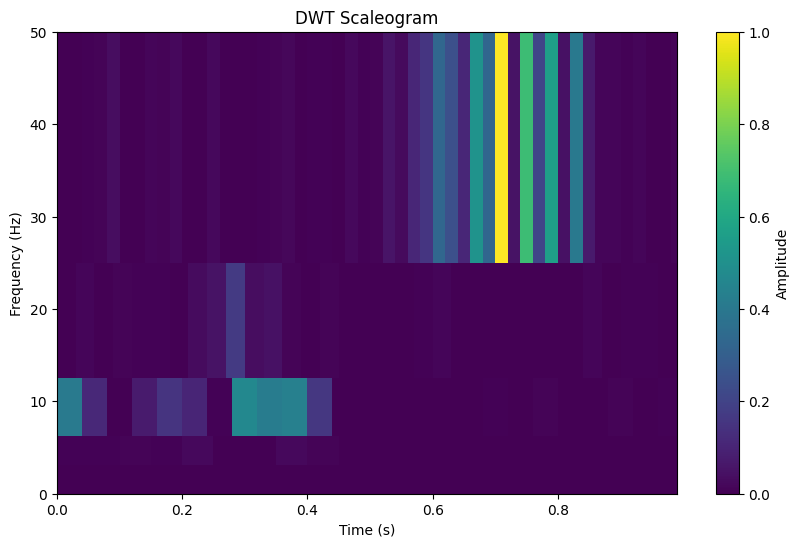

In [ ]:
# wavelets = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8']
# wavelets = ['coif1', 'coif2', 'coif3', 'coif4', 'coif5']
wavelets = ['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8']

for wavelet in wavelets:
    print(f"Wavelet: {wavelet}")
    max_level = pywt.dwt_max_level(len(signal_1), wavelet)
    coefs = pywt.wavedec(signal_1, wavelet, level=10)
    plot_dwt_scaleogram_freq(fs, coefs, 10, t, signal_1)

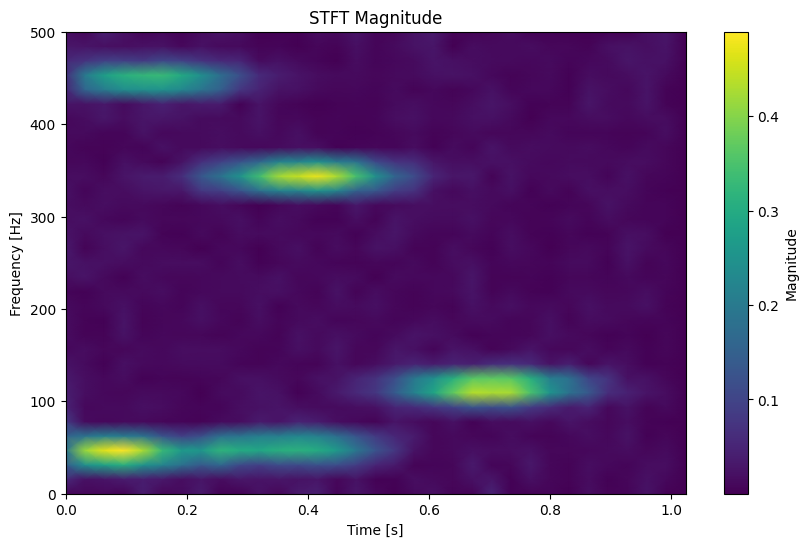

In [76]:
# do the stft
from scipy.signal import stft

# Compute the Short-Time Fourier Transform (STFT)
f, t_stft, Zxx = stft(signal_1, fs=fs, nperseg=64)

# Plot the STFT
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.show()

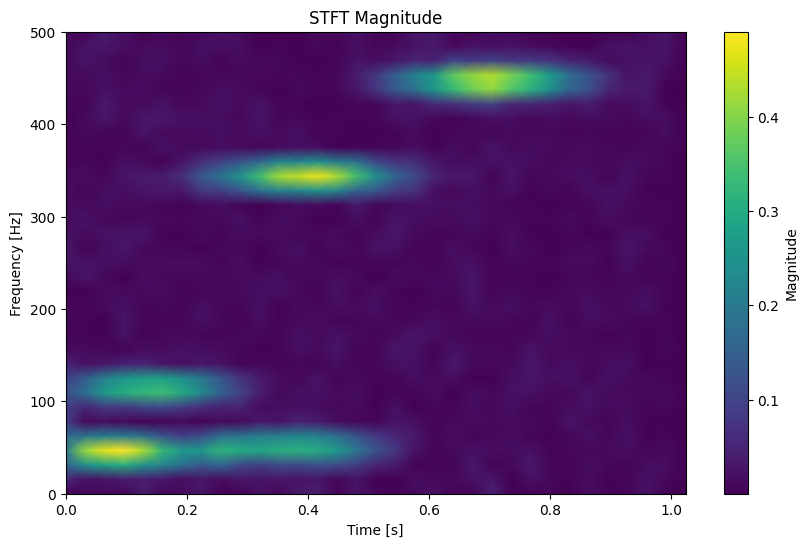

In [77]:
# Compute the Short-Time Fourier Transform (STFT)
f, t_stft, Zxx = stft(signal_2, fs=fs, nperseg=64)

# Plot the STFT
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.show()

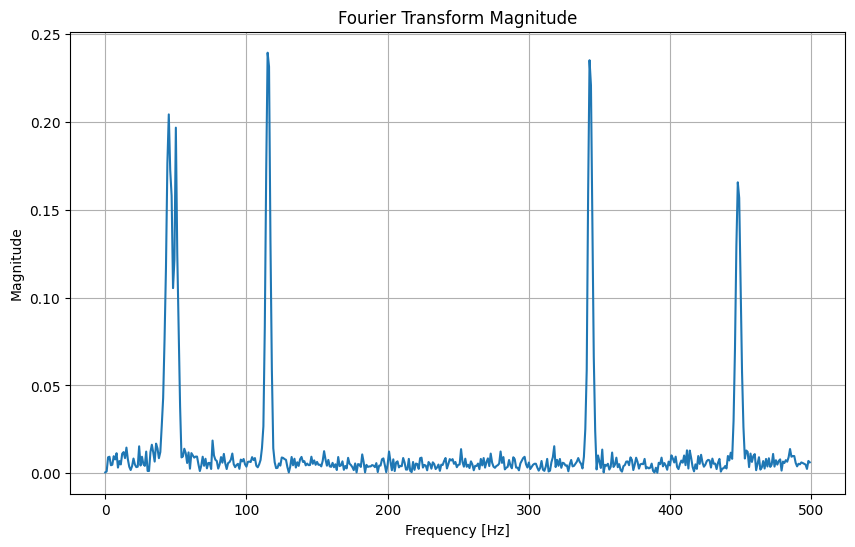

In [78]:
# do the fourier transform
from scipy.fft import fft, fftfreq

# Compute the Fourier Transform
N = len(signal_1)
T = 1.0 / fs
yf = fft(signal_1)
xf = fftfreq(N, T)[:N//2]

# Plot the Fourier Transform
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('Fourier Transform Magnitude')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

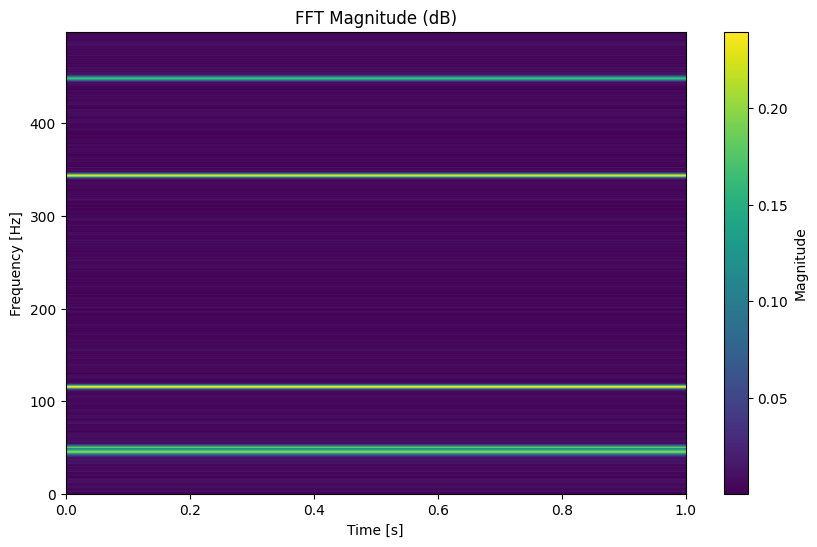

In [79]:
# Tile the FFT across time
mag = 2.0/N * np.abs(yf[:N//2])
scalogram = np.tile(mag[:, np.newaxis], (1, fs))

plt.figure(figsize=(10, 6))
plt.imshow(scalogram, aspect='auto', origin='lower',
           extent=[0, 1, xf[0], xf[-1]], cmap='viridis')
plt.title('FFT Magnitude (dB)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.show()

### Testing flextime with the simulated data

In [1]:
from src.models.simple import SimpleCNN
import torch

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# load the model
model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=31)

# load the model weights
model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_3.pth", map_location=torch.device('mps')))
model.to(device)

Using device: mps


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SimpleCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(31,), stride=(1,), padding=(15,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 2, kernel_size=(31,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)

In [2]:
# Load and shape synthetic test data
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_1"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# create the dataset
dataset = TensorDataset(x, y)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128, shuffle=True)


(10000, 1, 1000)
(10000,)


In [3]:
print(f"Number of batches: {len(test_loader)}")
for batch in test_loader:
    print(f"Batch shape {len(batch)}, sample and label")
    x, y = batch
    print(f"Sample batch size {len(x)}")
    print(f"Label batch size {len(y)}")
    print(f"Sample shape {x.shape}")
    print(f"Label shape {y.shape}")
    break

Number of batches: 79
Batch shape 2, sample and label
Sample batch size 128
Label batch size 128
Sample shape torch.Size([128, 1, 1000])
Label shape torch.Size([128])


In [4]:
import pickle
from src.evaluation.evaluation import evaluate_attributions

attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

# prediction
for batch in test_loader:
    # get data
    x, y = batch
    x = x.to(device)
    output = model(x)

    predictions.append(output)
    labels.append(y)

# concatenat the predictions and the labels through the first dim
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)

In [5]:
print(predictions.shape)
print(predictions[0])
print(labels.shape)

torch.Size([10000, 2])
tensor([-4.9084,  5.6094], device='mps:0', grad_fn=<SelectBackward0>)
torch.Size([10000])


In [6]:
correct = 0
for i in range(len(predictions)):
    if predictions[i].argmax() == labels[i]:
        correct += 1

print(f"Accuracy: {correct / len(predictions)}")

Accuracy: 1.0


In [7]:
# save it in the attributions dict
attributions['predictions'] = predictions
attributions['labels'] = labels

In [8]:
# evaluate flextime
fs = 1000
batch_size = 128
n_filters = 128
numtaps = 501
key_ = f'flexime_{n_filters}_{numtaps}_{batch_size}'

In [9]:
from src.attribution import compute_attribution
from types import SimpleNamespace

method = 'flextime'

args = SimpleNamespace(n_taps=numtaps, n_filters=n_filters, sample_freq=fs, time_len=fs)
print(args.n_taps)
print(args.n_filters)
print(args.sample_freq)
print(args.time_len)

attrs, masks = compute_attribution(method = method, model = model, test_loader= test_loader, args = args, device=device)

501
128
1000
1000
Batch 0 of 79
Sample 0 of 128
[Epoch 0] Loss: 0.7767, Target: 0.326657, Reg: 0.450000, L1: 0.4913
[Epoch 10] Loss: 0.6726, Target: 0.314474, Reg: 0.358110, L1: 0.3986
[Epoch 20] Loss: 0.5755, Target: 0.313901, Reg: 0.261639, L1: 0.3019
[Epoch 30] Loss: 0.4779, Target: 0.313906, Reg: 0.163977, L1: 0.2042
[Epoch 40] Loss: 0.3800, Target: 0.314041, Reg: 0.065918, L1: 0.1061
[Epoch 50] Loss: 0.3141, Target: 0.314110, Reg: 0.000000, L1: 0.0177
[Epoch 60] Loss: 0.3138, Target: 0.313801, Reg: 0.000000, L1: 0.0153
[Epoch 70] Loss: 0.3136, Target: 0.313578, Reg: 0.000000, L1: 0.0149
[Epoch 80] Loss: 0.3135, Target: 0.313470, Reg: 0.000000, L1: 0.0150
Sample 1 of 128
[Epoch 0] Loss: 0.8163, Target: 0.366288, Reg: 0.450000, L1: 0.4908
[Epoch 10] Loss: 0.6742, Target: 0.317337, Reg: 0.356881, L1: 0.3975
[Epoch 20] Loss: 0.5770, Target: 0.314319, Reg: 0.262701, L1: 0.3033
[Epoch 30] Loss: 0.4819, Target: 0.313784, Reg: 0.168069, L1: 0.2086
[Epoch 40] Loss: 0.3867, Target: 0.313615

In [10]:
attributions[key_] = attrs
attributions[f'filtermasks_{key_}'] = masks

In [11]:
# read data
folder = 'public/simple/'
path = f'{folder}{key_}_results_1.pkl'

with open(path, 'rb') as f:
    attributions = pickle.load(f)
print(f"Attributions loaded from {path}")

Attributions loaded from public/simple/flexime_128_501_128_results_1.pkl


In [12]:
print(attributions.keys())
print(key_)
print(len(attributions[key_]))
print(len(attrs[0]))
print(len(masks))
print(len(test_loader))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'flexime_128_501_128', 'filtermasks_flexime_128_501_128'])
flexime_128_501_128
1
128
79
79


In [13]:
print(type(attributions[key_]))
print(len(attributions[key_]))
print(len(attributions[key_][0]))
print(len(attributions[key_][0][0]))
print(len(attributions[key_][0][0][0]))

<class 'list'>
1
128
501
1


In [14]:
key_2 = f'filtermasks_{key_}'
print(type(attributions[key_2]))
print(len(attributions[key_2]))
print(len(attributions[key_2][0]))
print(len(attributions[key_2][0][0]))

<class 'list'>
1
128
128


In [15]:
# compute accuracy scores
quantiles = np.arange(0, 1.05, 0.05)
for mode in ['deletion', 'insertion']:
    if not mode in attributions.keys():
        attributions[mode] = {}
    
    acc_scores = evaluate_attributions(model, test_loader, attributions[key_], quantiles=quantiles, mode=mode, device=device)
    attributions[mode][key_] = acc_scores

In [16]:
print(attributions.keys())
print(len(quantiles))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'flexime_128_501_128', 'filtermasks_flexime_128_501_128'])
21


In [35]:
# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['insertion'].keys():
    print(k)
    print(len(attributions['insertion'][k]))
    print(len(attributions['insertion'][k][0]))
    for val in range(len(attributions['insertion'][k])):
        print(attributions['insertion'][k][val])

flexime_128_501_128
3
21
[0.59375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5247913599014282, 0.9996600151062012, 0.9999815821647644, 0.999981164932251, 0.9999803304672241, 0.9999793767929077, 0.9999788999557495, 0.999978244304657, 0.9999776482582092, 0.9999772310256958, 0.9999769926071167, 0.999976396560669, 0.9999760389328003, 0.9999756813049316, 0.9999752044677734, 0.9999750256538391, 0.9999746084213257, 0.9999743700027466, 0.9999739527702332, 0.9999738335609436, 0.9999735951423645]
[0.3393024206161499, 0.00017006699636112899, 9.18974092201097e-06, 9.413720363227185e-06, 9.822561878536362e-06, 1.0311031473975163e-05, 1.058343787008198e-05, 1.0895423656620551e-05, 1.1199495020264294e-05, 1.1355953574820887e-05, 1.1488664313219488e-05, 1.1798785635619424e-05, 1.1964555596932769e-05, 1.2139642421971075e-05, 1.2388767572701909e-05, 1.2470721230783965e-05, 1.2685849469562527e-05, 1.283578785660211e-05, 1.3010407201363705e-05, 

In [18]:
from quantus.metrics import Complexity

complexities = {}
grad_complexties = {}
sensitivity = {}
rel_out_sens = {}
comp = Complexity()

In [19]:
for att in attributions:
    print(att)

deletion
insertion
predictions
labels
flexime_128_501_128
filtermasks_flexime_128_501_128


In [20]:
for att in attributions:
    if att == 'insertion':
        print(attributions['insertion'].keys())
    
for key in attributions['insertion'].keys():
    if not key in complexities.keys():
        print('first')
        complexities[key] = []
        grad_complexties[key] = []

    scores = []
    grad_scores = []

    for i in range(len(attributions[key])):
        expl = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
        expl = expl.to(dtype=torch.float32).numpy()
        
        ex = np.maximum(attributions[key][i].numpy(), 0)
        if 'filterbank' in key:
            ex = np.transpose(ex, (0, 2, 1))

        # min max normalize
        ex_min = np.min(ex, axis = -1, keepdims=True)
        ex_max = np.max(ex, axis = -1, keepdims=True)
        ex = (ex - ex_min) / (ex_max - ex_min + 1e-10)
        # ex = (ex - np.min(ex, axis = -1, keepdims=True)) / (np.max(ex, axis = -1, keepdims=True) - np.min(ex, axis = -1, keepdims=True) + 1e-10)
        expl_grad = np.abs(np.diff(ex, axis = -1)).sum(axis=-1)
        expl_grad = np.reshape(expl_grad, (attributions[key][i].shape[0], -1))

        expl = np.maximum(expl, 0)
        # check if all expl values are zero
        if np.all(expl == 0):
            print("All zeros")
            # add a small epsilon to avoid division by zero
            expl = np.ones_like(expl) * 1e-10

        # to compute complexities it has to be a numpy float32 otherwise err
        complexity = comp.evaluate_batch(expl, expl)
        complexity = np.nan_to_num(complexity)
        expl_grad = np.nan_to_num(expl_grad)
        scores += complexity.tolist()
        grad_scores += list(expl_grad)

    complexities[key].append(np.mean(scores))
    grad_complexties[key].append(np.mean(grad_scores))

print(complexities)
print(grad_complexties)

dict_keys(['flexime_128_501_128'])
first
{'flexime_128_501_128': [np.float64(3.6366535955134816)]}
{'flexime_128_501_128': [np.float64(0.0)]}


In [ ]:
# dump to file
folder = 'public/simple/'
path = f'{folder}{key_}_results_2.pkl'

with open(path, 'wb') as f:
    pickle.dump(attributions, f)
print(f"Saved to {path}")

Saved to public/simple/flexime_128_501_128_results_1.pkl


In [26]:
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt

def plot_freq_heatmap(signal, attribution, fs=1000):
    # Compute FFT
    N = len(signal)
    freq = fftfreq(N, d=1/fs)  # Frequency bins
    magnitude = np.abs(fft(signal))  # Magnitude of FFT

    # Keep only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    magnitude = magnitude[pos_mask]

    # Normalize attribution scores to [0,1]
    attr_resized = np.interp(freq, np.linspace(freq.min(), freq.max(), len(attribution)), attribution)
    attr_norm = (attr_resized - np.min(attr_resized)) / (np.max(attr_resized) - np.min(attr_resized) + 1e-10)

    # Create a 2D grid for heatmap
    freq_grid, mag_grid = np.meshgrid(freq, magnitude)
    attr_grid = np.tile(attr_norm[:-1], (len(magnitude) - 1, 1))  # Repeat attribution scores along the magnitude axis

    # Plot heatmap
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude, label="FFT Magnitude", color='black', alpha=0.6)
    plt.pcolormesh(freq_grid, mag_grid, attr_grid, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.title("Attribution Heatmap in Frequency Domain")
    plt.show()

(array([0, 1]), array([5000, 5000]))
1
(128, 128)


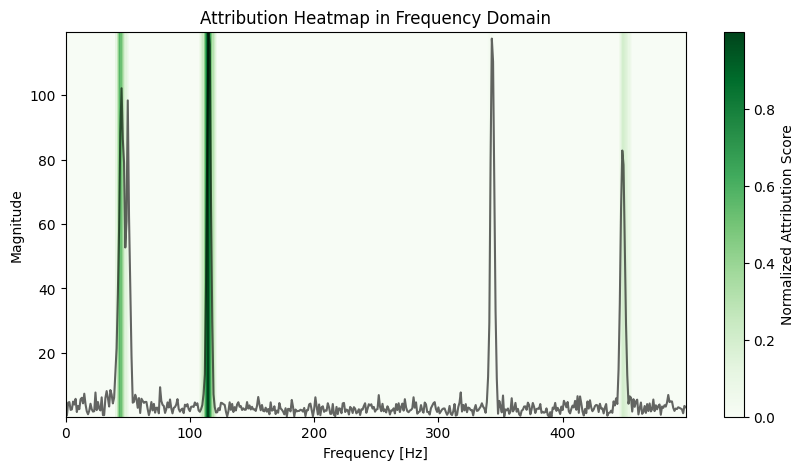

Prediction: 1, Label: 1


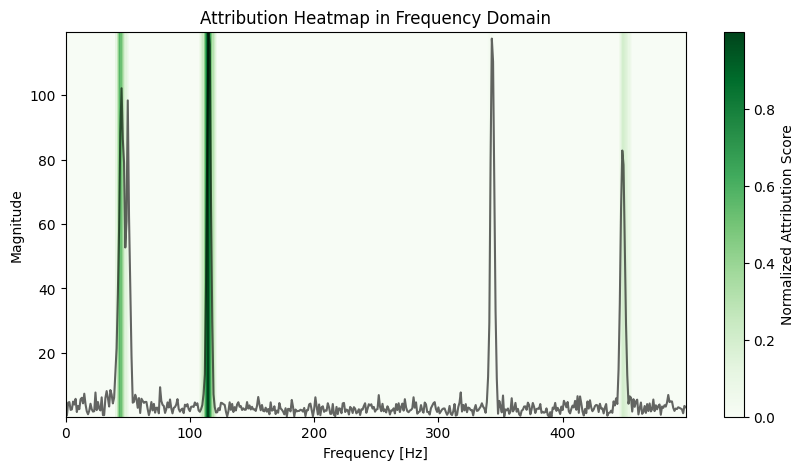

Prediction: 1, Label: 1


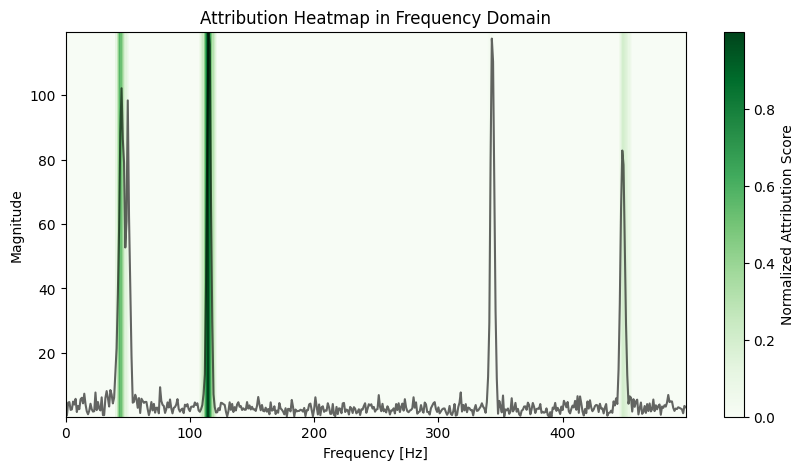

Prediction: 1, Label: 1


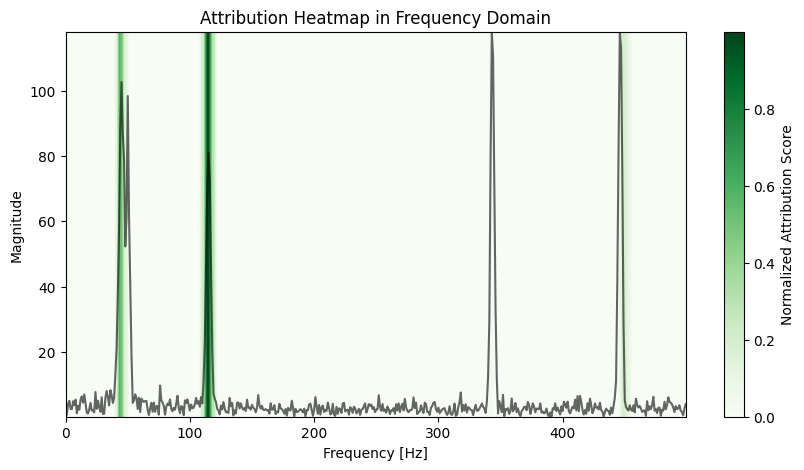

Prediction: 1, Label: 1


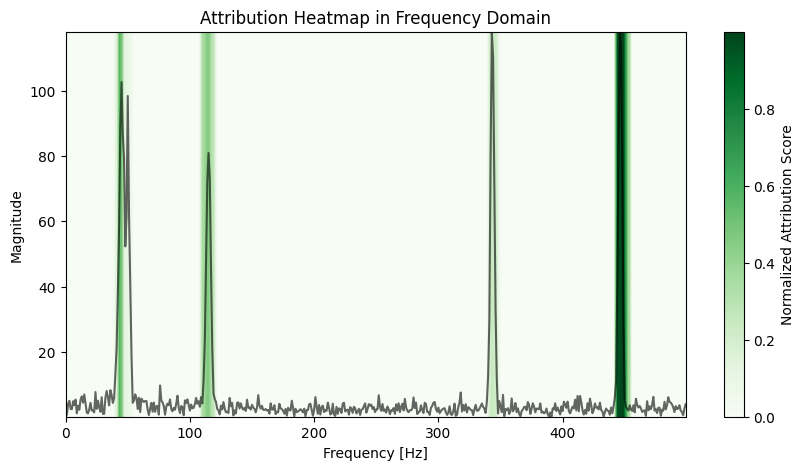

Prediction: 1, Label: 1


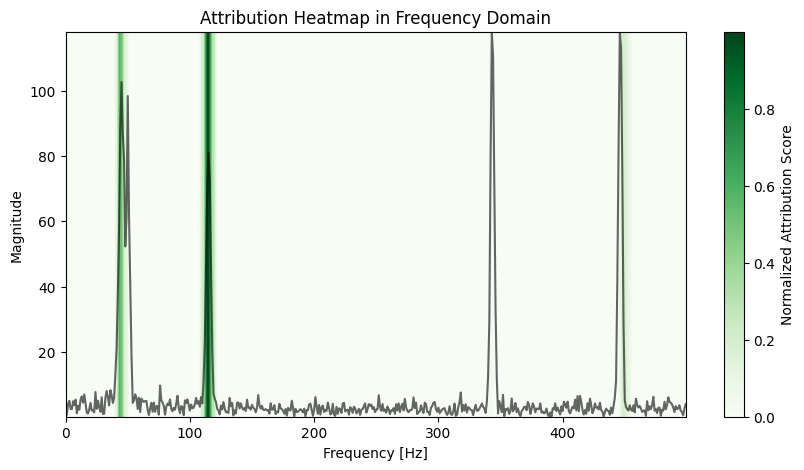

Prediction: 0, Label: 0


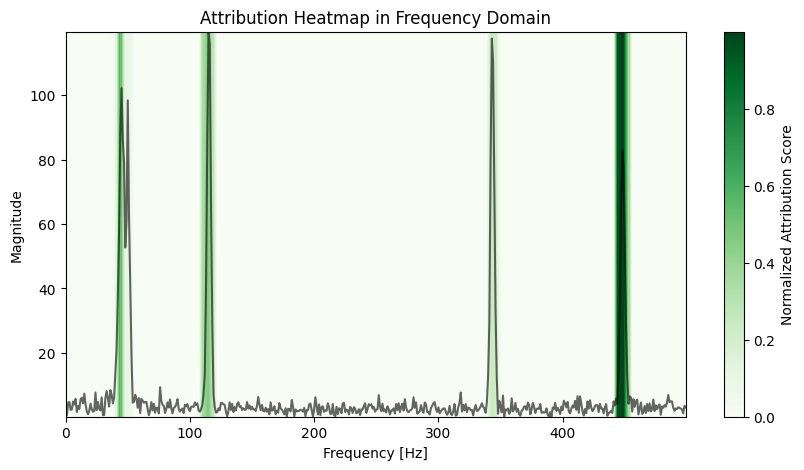

Prediction: 1, Label: 1


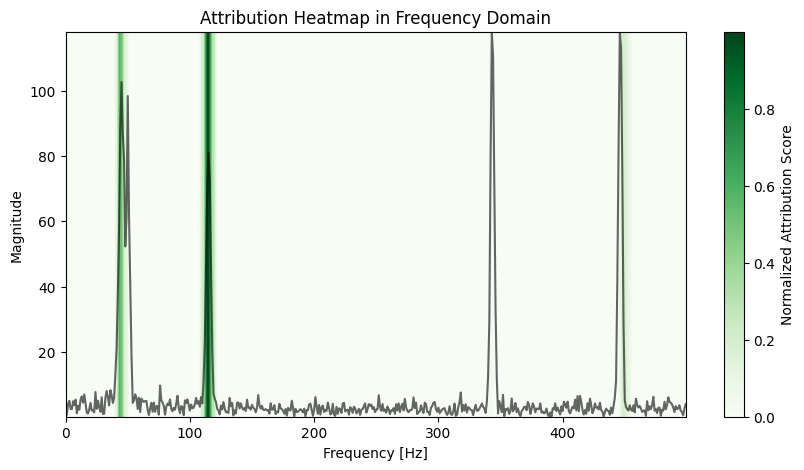

Prediction: 1, Label: 1


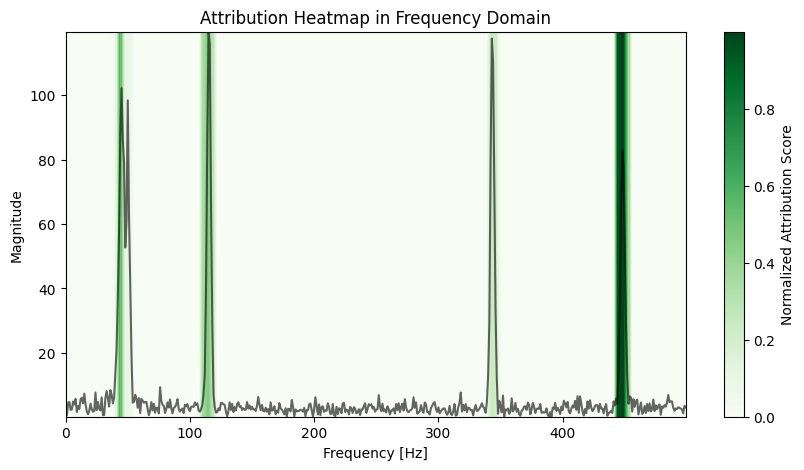

Prediction: 1, Label: 1


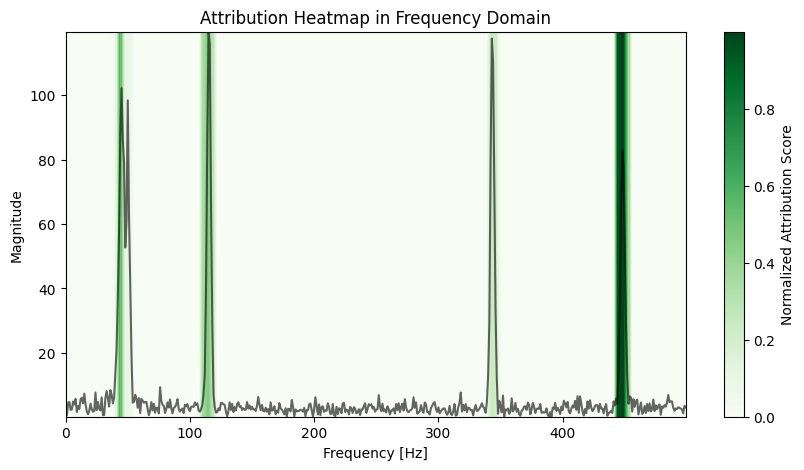

Prediction: 0, Label: 0


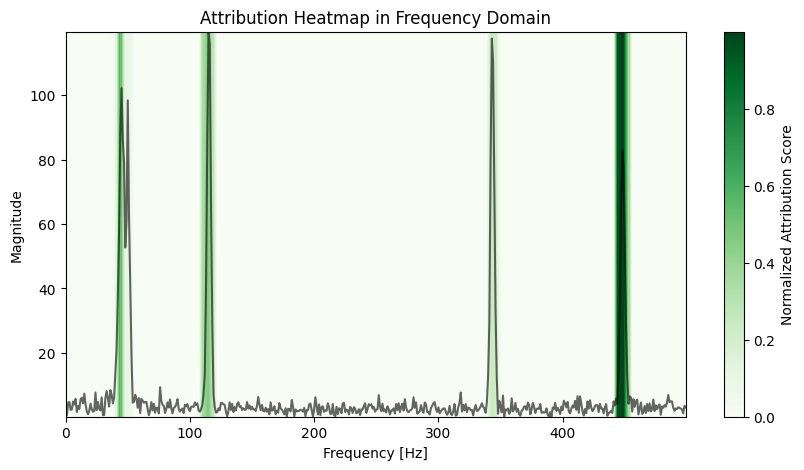

Prediction: 1, Label: 1


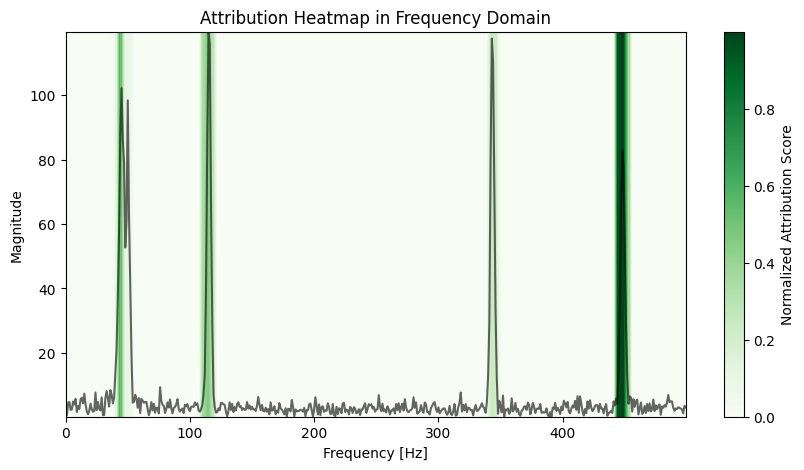

Prediction: 1, Label: 1


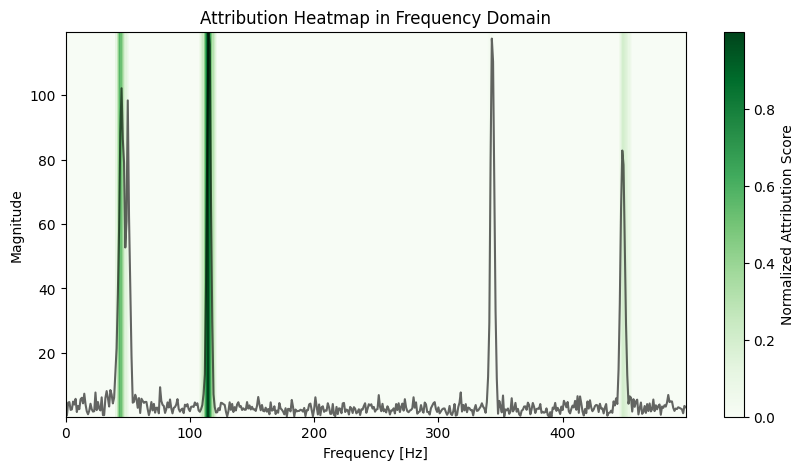

Prediction: 0, Label: 0


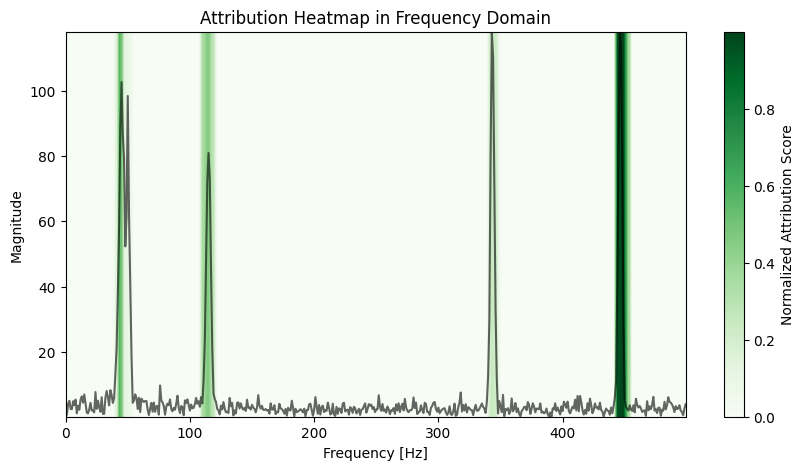

Prediction: 1, Label: 1


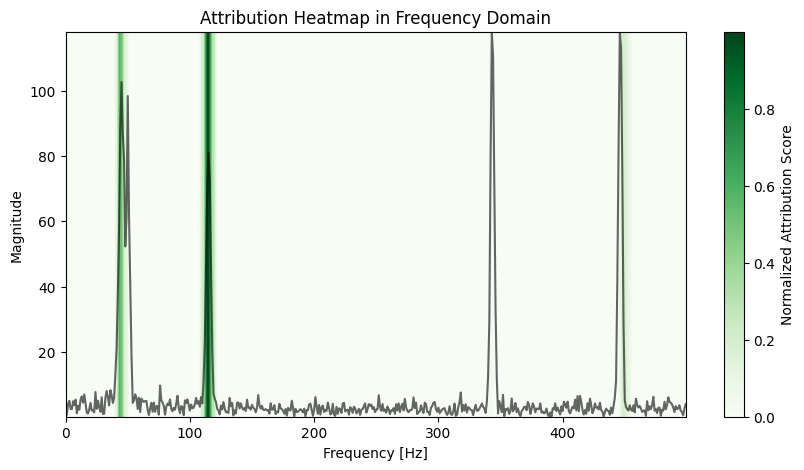

Prediction: 0, Label: 0


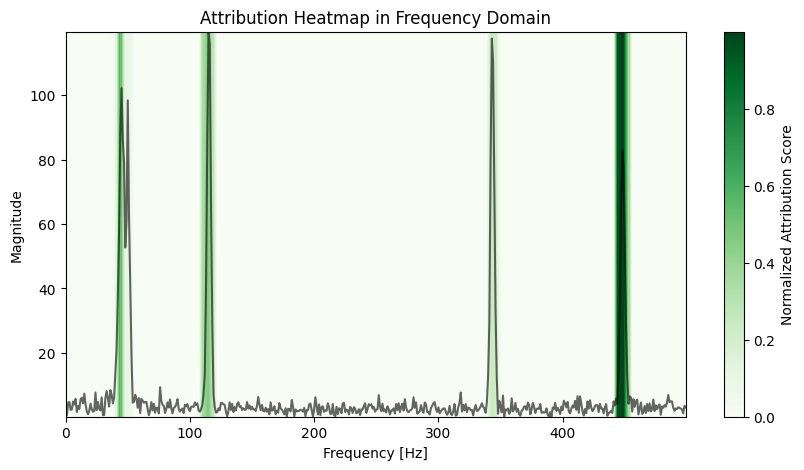

Prediction: 0, Label: 0


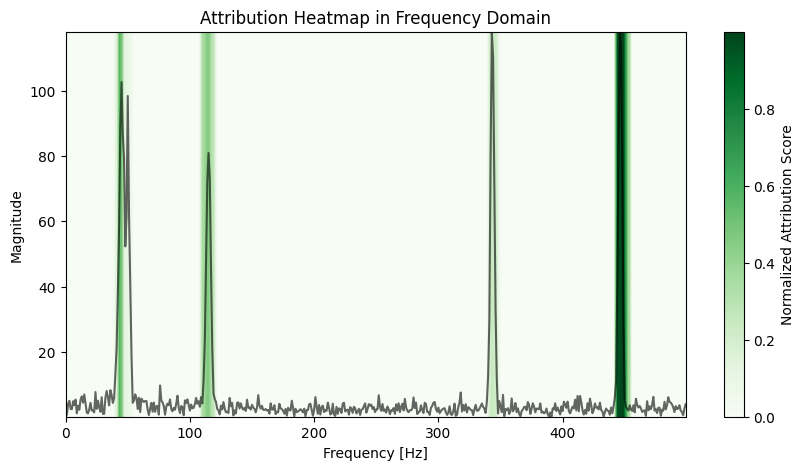

Prediction: 1, Label: 1


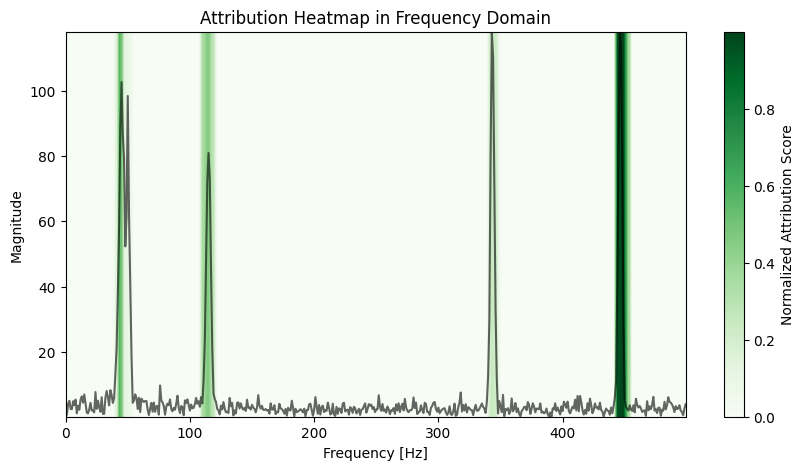

Prediction: 1, Label: 1


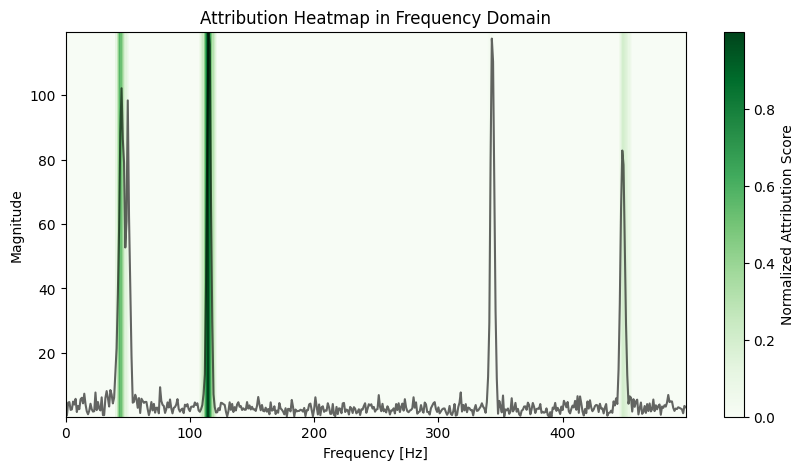

Prediction: 1, Label: 1


In [30]:
# show the mask avg for each class
counts = np.unique(labels, return_counts=True)
print(counts)


# plot the scores as a heatmap on the original signal
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()

    print(len(attributions['filtermasks_flexime_128_501_128']))
    print(attributions['filtermasks_flexime_128_501_128'][0].shape)

    # plot 5 samples
    for i in range(1, 20):
        plot_freq_heatmap(x[i][0], attributions['filtermasks_flexime_128_501_128'][0][i])

        # print the prediction and the label of the sample
        print(f"Prediction: {predictions[i].argmax()}, Label: {labels[i]}")
    break

In [32]:
import pywt

def plot_scaleogram_fft_heatmap(signal, attribution, fs=1000):
    N = len(signal)
    freq = fftfreq(N, d=1/fs)
    len(freq)

    # Keep only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]

    time = np.linspace(0, len(signal) / fs, len(signal))

    # Normalize attribution scores to [0,1]
    attr_resized = np.interp(freq, np.linspace(freq.min(), freq.max(), len(attribution)), attribution)
    attr_norm = (attr_resized - np.min(attr_resized)) / (np.max(attr_resized) - np.min(attr_resized) + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq)
    attr_grid = np.tile(attr_norm[:-1], (len(time) - 1, 1))  # Repeat attribution scores along the magnitude axis

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_grid.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title('Attribution')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

1
(128, 128)


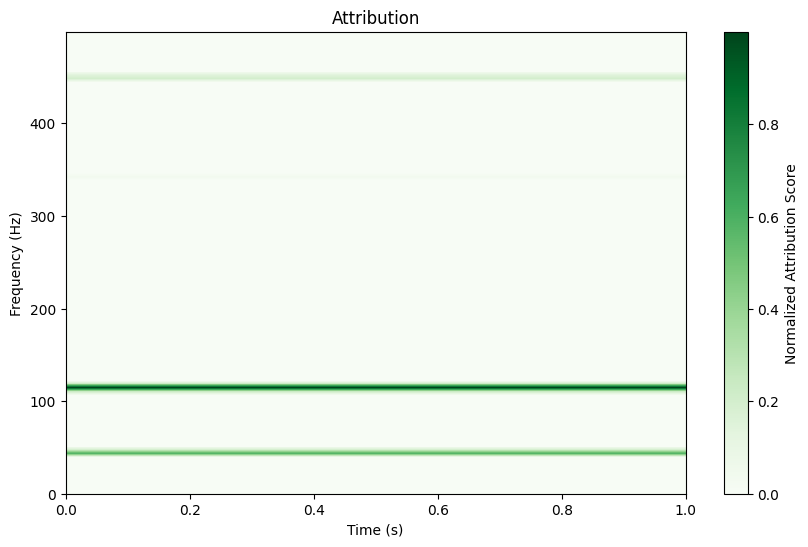

Prediction: 1, Label: 1


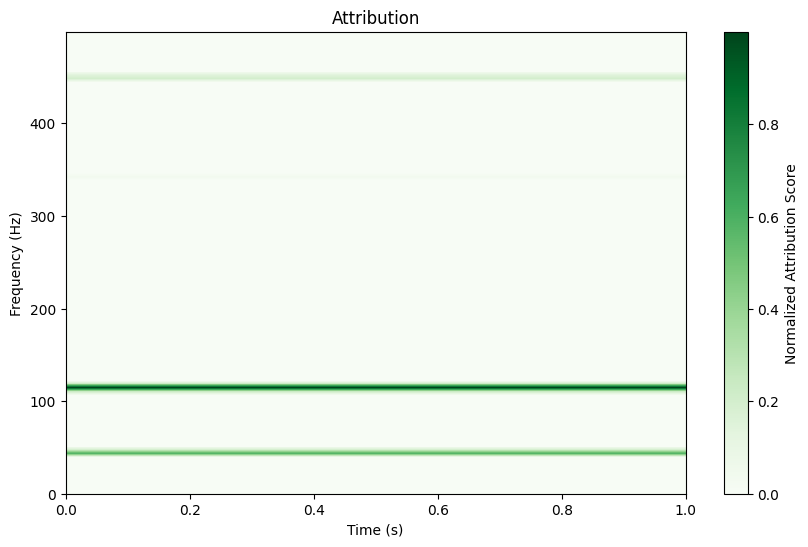

Prediction: 1, Label: 1


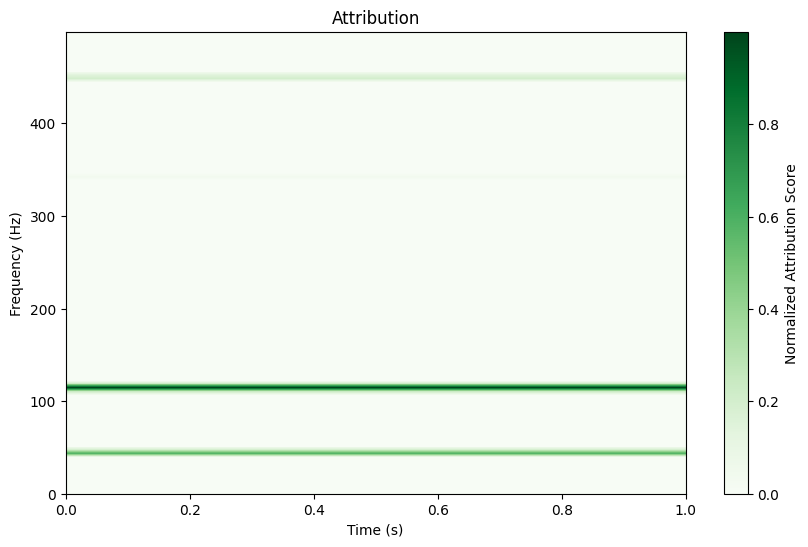

Prediction: 1, Label: 1


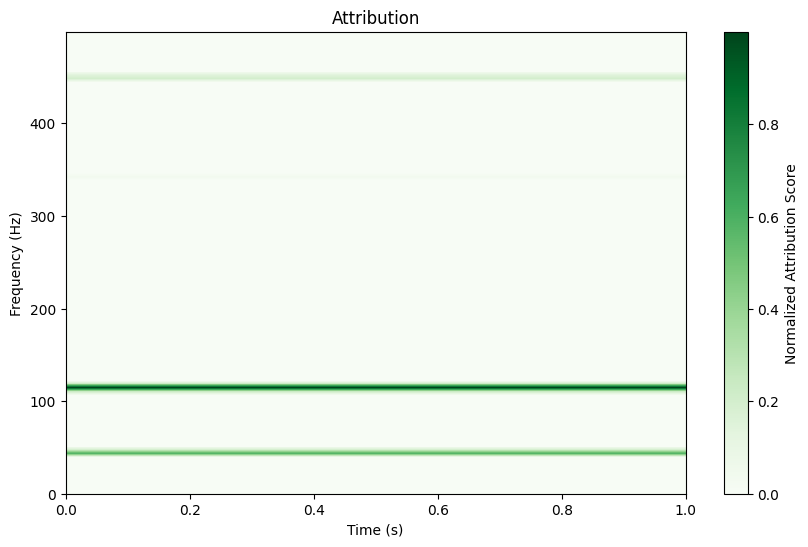

Prediction: 1, Label: 1


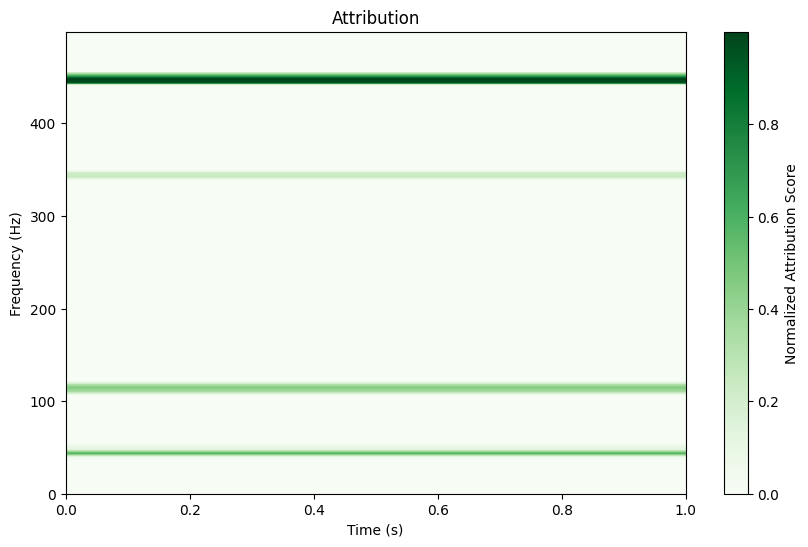

Prediction: 1, Label: 1


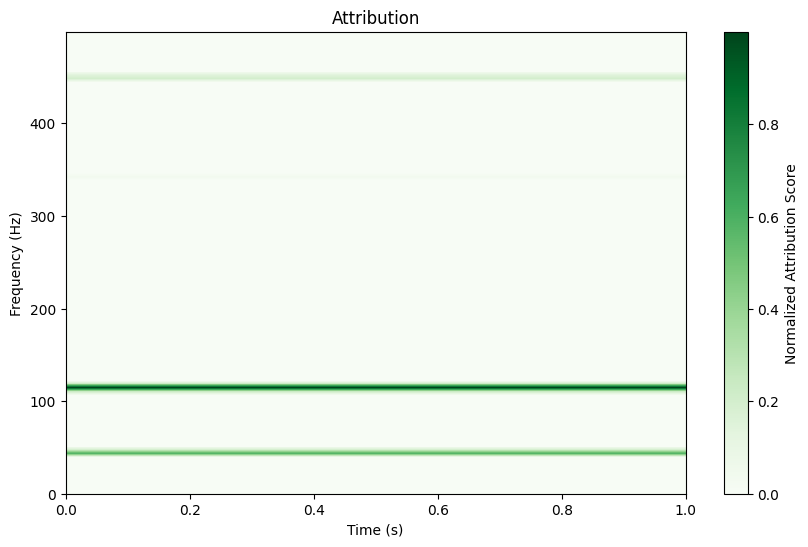

Prediction: 0, Label: 0


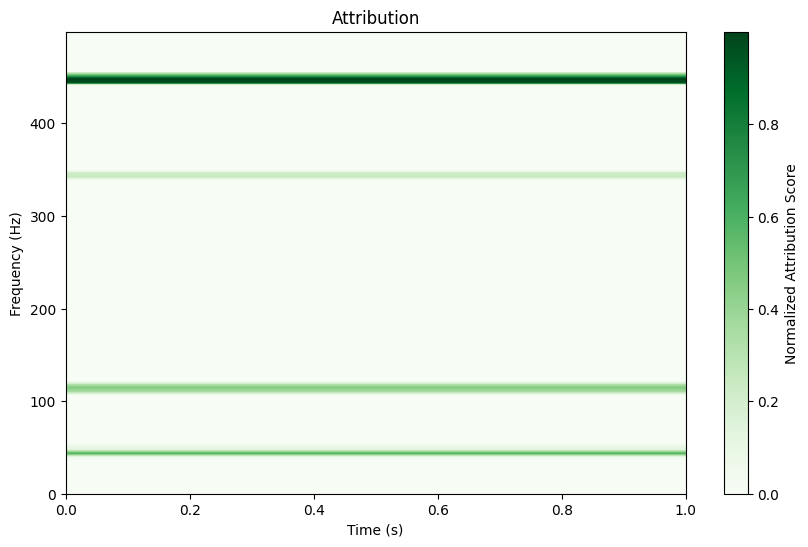

Prediction: 1, Label: 1


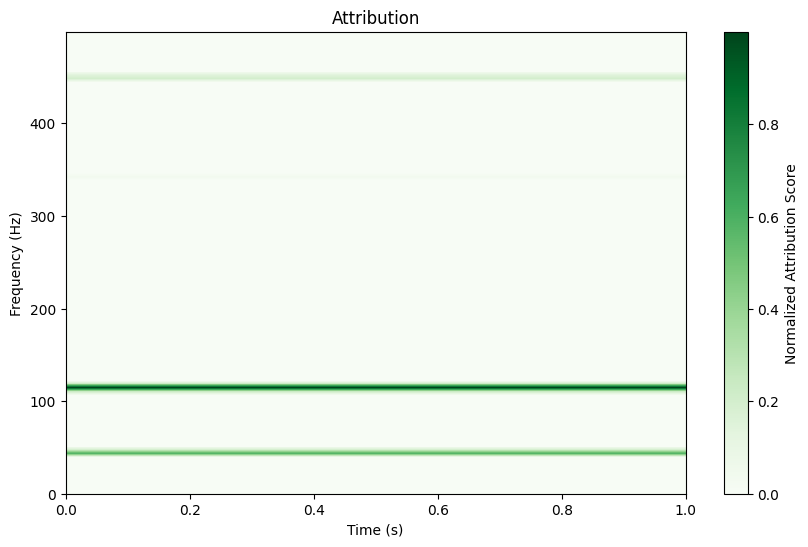

Prediction: 1, Label: 1


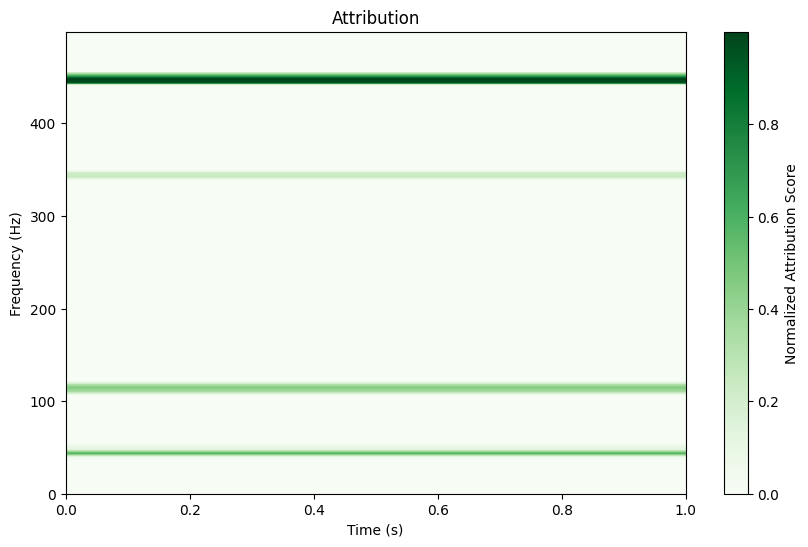

Prediction: 1, Label: 1


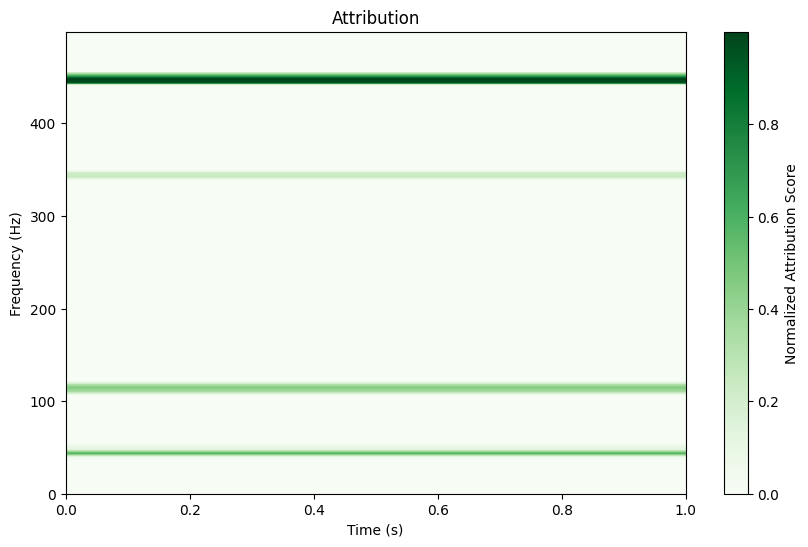

Prediction: 0, Label: 0


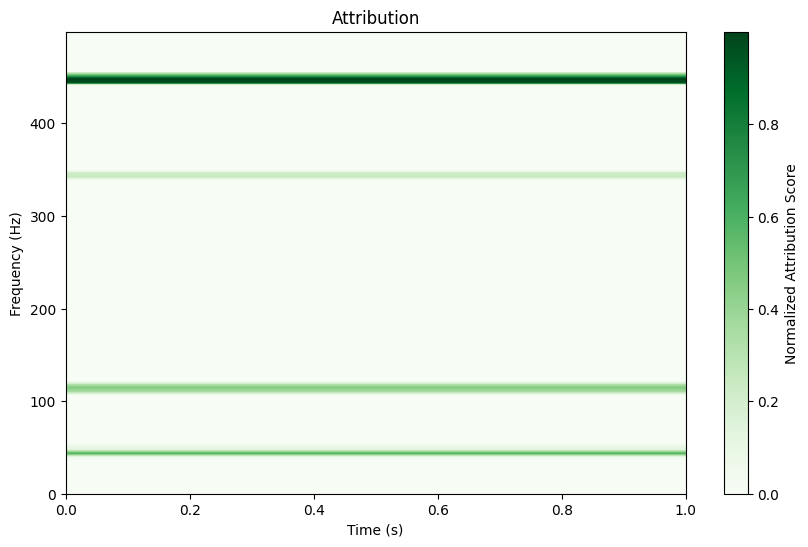

Prediction: 1, Label: 1


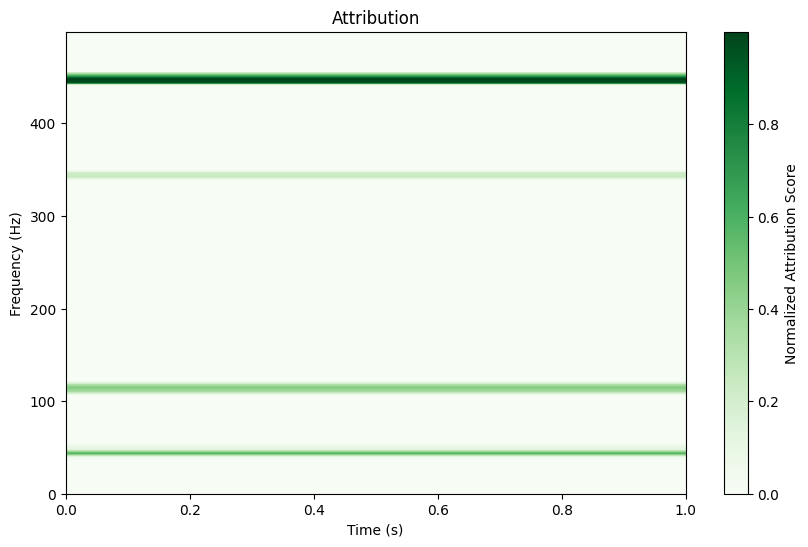

Prediction: 1, Label: 1


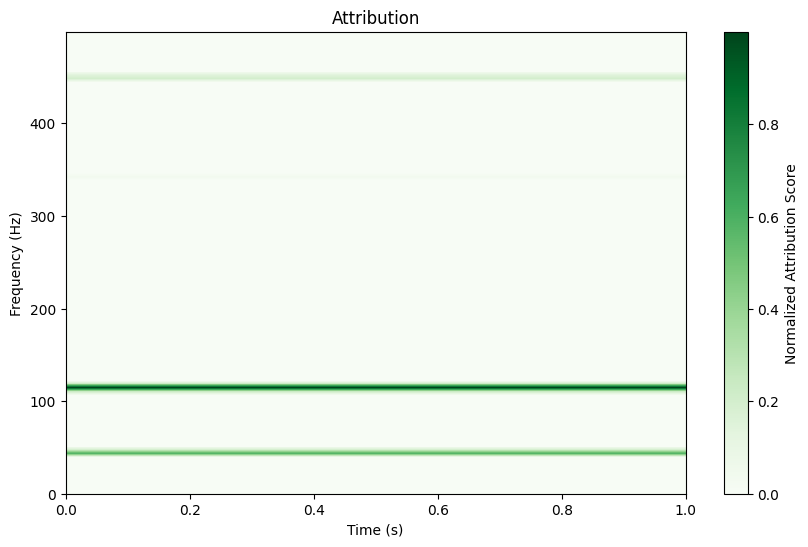

Prediction: 0, Label: 0


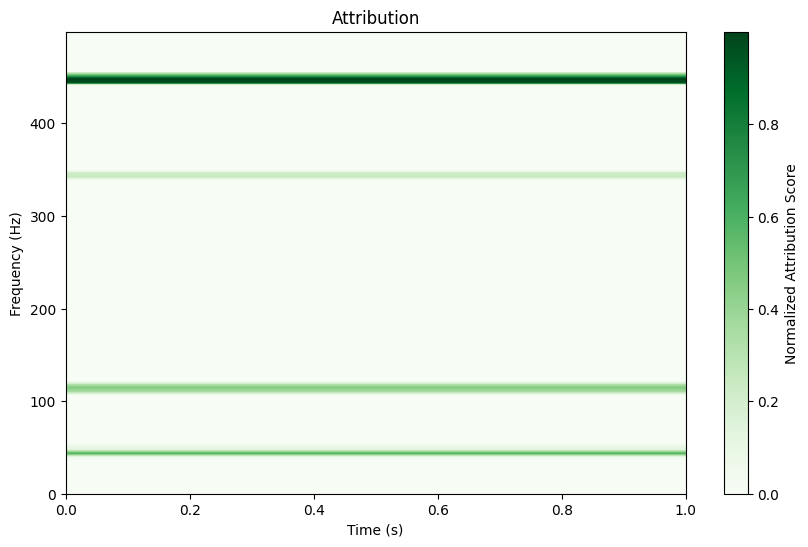

Prediction: 1, Label: 1


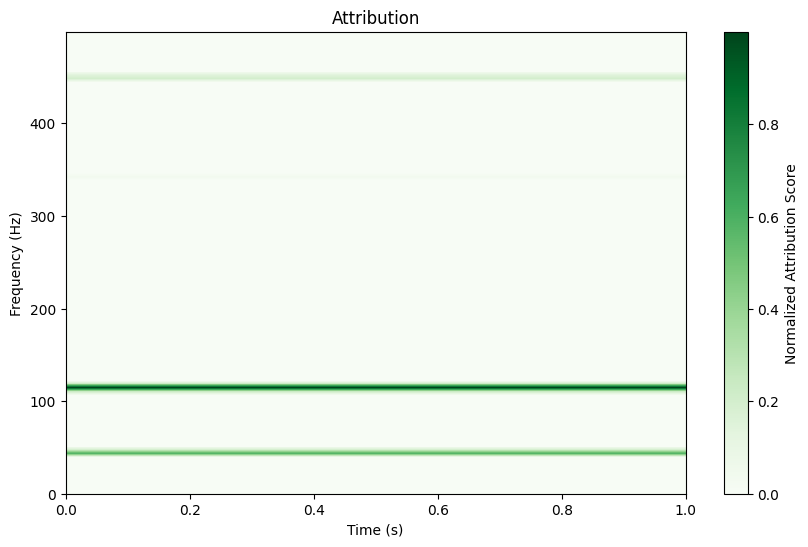

Prediction: 0, Label: 0


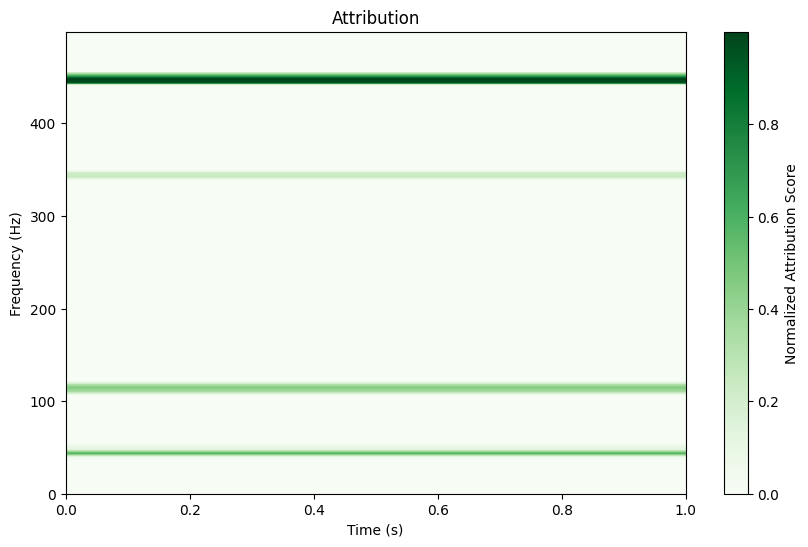

Prediction: 0, Label: 0


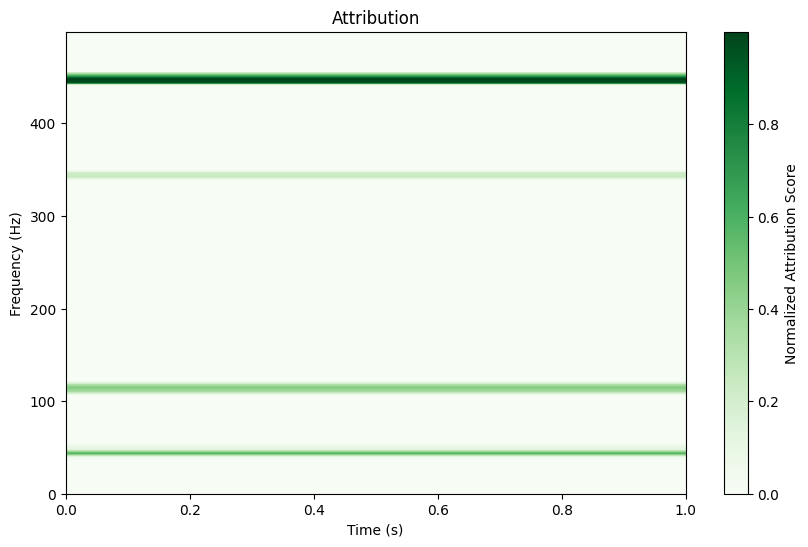

Prediction: 1, Label: 1


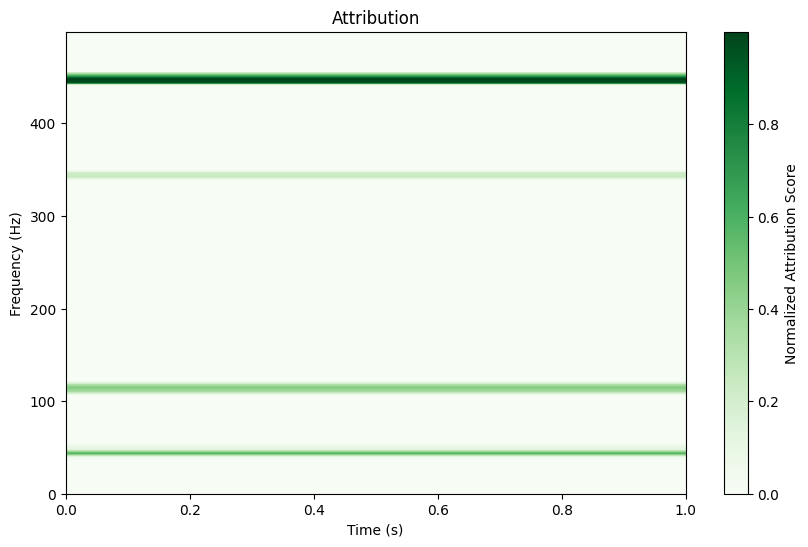

Prediction: 1, Label: 1


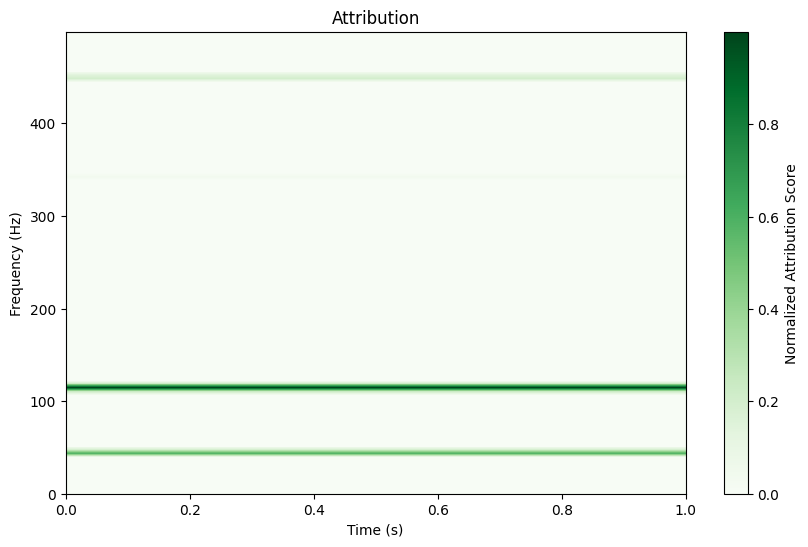

Prediction: 1, Label: 1


In [34]:
# plot the scores as a heatmap on the original signal
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()

    print(len(attributions['filtermasks_flexime_128_501_128']))
    print(attributions['filtermasks_flexime_128_501_128'][0].shape)

    # plot 5 samples
    for i in range(1, 20):
        plot_scaleogram_fft_heatmap(x[i][0], attributions['filtermasks_flexime_128_501_128'][0][i])

        # print the prediction and the label of the sample
        print(f"Prediction: {predictions[i].argmax()}, Label: {labels[i]}")
    break

In [150]:
def get_wavelet_bands(coeffs, data, normalize=True, rescale=True):
    upsampled_coeffs = []

    for level, coeff in enumerate(coeffs):
        factor = int(np.ceil(len(data) / len(coeff)))
        upsampled = np.repeat(coeff, factor)[:len(data)]
        
        if rescale:
            upsampled *= 2 ** level
        if normalize:
            upsampled = (upsampled - np.min(upsampled)) / (np.max(upsampled) - np.min(upsampled) + 1e-8)

        upsampled_coeffs.append(upsampled)

    return np.array(upsampled_coeffs)

In [159]:
signal = x[0][0]
print(signal.shape)

coeffs = pywt.wavedec(signal, 'db1')
print(len(coeffs))

for c in coeffs:
    print(len(c))

bands = get_wavelet_bands(coeffs, signal)

bands = bands[::-1]

bands_downsampled = []
for i, b in enumerate(bands):
    if i == len(bands) - 1:
        b = b[1::(2**(i))]
    else:
        b = b[1::(2**(i+1))]
    print(len(b))
    bands_downsampled.append(b)

bands_downsampled = bands_downsampled[::-1]


(1000,)
10
2
2
4
8
16
32
63
125
250
500
500
250
125
63
32
16
8
4
2
2


In [ ]:
# given a signal 

wavelet_transform = []
coeffs = pywt.wavedec(x[0], 'db1')
for i, coeff in enumerate(coeffs):
    factor = math.ceil(len(x[0]) / len(coeff))
    upsampled = np.repeat(coeff, factor)[:len(x[0])]
    wavelet_transform.append(upsampled)

# downsample the wavelet transform to the original coeffs size
wavelet_transform = np.array(wavelet_transform)

for i in range(len(wavelet_transform)):
    wavelet_transform[i] = np.interp(np.linspace(0, len(wavelet_transform[i]), len(x[0])), np.arange(len(wavelet_transform[i])), wavelet_transform[i])